In [59]:
from collections import Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from konlpy.tag import Okt

from source.lib import STOP_WORDS

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [60]:
# testing
df = pd.read_csv('./data/processed/df.csv')

In [61]:
df.head(3)

,review,score,sentiment
0,판타지를 넘어 영화 역사에 남을 명작이다 내가 이걸 왜 극장에서 못봤을까 폰으로 봤...,10.0,1.0
1,이집트여행하는느낌의 영화,8.0,1.0
2,목포 연설 장면은 넋을 잃고 보게 된다,10.0,1.0


In [62]:
df.tail(3)

,review,score,sentiment
9328,그래도 최근에 나왔던 영화들에 비해 내용이 되게 흥미진진했음 리암 니슨이 덜뛰는 대...,10.0,1.0
9329,누구나 시작은 어설픈 법 그래서 더 매력적인 히어로,10.0,1.0
9330,병과 싸우기 위해서는 공부해야 한다,7.0,0.0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9331 entries, 0 to 9330
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review     9331 non-null   object 
 1   score      9331 non-null   float64
 2   sentiment  9331 non-null   float64
dtypes: float64(2), object(1)
memory usage: 218.8+ KB


<AxesSubplot:xlabel='sentiment', ylabel='count'>

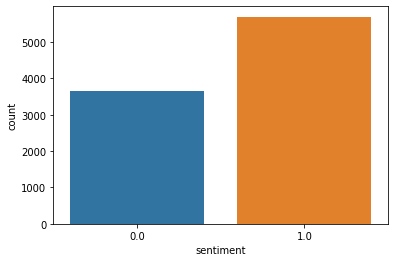

In [64]:
sns.countplot(data=df,x='sentiment')

In [65]:
okt = Okt()

In [66]:
df.loc[:,'review']=df['review'].apply(lambda x : okt.morphs(x,stem=True))

In [67]:
words = Counter(sum(df['review'].tolist(),[]))
words.__len__()

12589

In [68]:
stop_words = [w for w,i in words.items() if i<=5]

print(stop_words[:5])
print(stop_words.__len__())

stop_words_set = set(stop_words)

['폰', '이집트', '목포', '넋', '올레']
9709


In [69]:
X = df['review'].apply(lambda x: list(filter(lambda y:y not in STOP_WORDS and y not in stop_words_set,x))).tolist()

print(X[:5])

[['판타지', '넘다', '영화', '역사', '남', '명작', '내', '걸', '극장', '못', '보다', '보다', '감동', '과는', '비교', '안되다'], ['여행', '느낌', '영화'], ['연설', '장면', '잃다', '보다', '되다'], ['그렇다', '뻔하다', '반전', '결말'], ['더', '배트맨', '조커', '처럼', '몰입', '감', '추천', '반대', '지루하다', '비', '추천']]


In [70]:
x_len = X.__len__()

train_len = x_len // 10 * 8

In [71]:
number_vocab = set(sum(X,[])).__len__()
tokenizer = Tokenizer(number_vocab)

tokenizer.fit_on_texts(X[:train_len])

X_train = tokenizer.texts_to_sequences(X[:train_len])
X_test = tokenizer.texts_to_sequences(X[train_len:])

y_train = np.array(df['sentiment'][:train_len])
y_test = np.array(df['sentiment'][train_len:])

In [72]:
print('X_train : ',X_train.__len__())
print('y_train : ',y_train.__len__())
print()
print('X_test : ',X_test.__len__())
print('y_test : ',y_test.__len__())

X_train :  7464
y_train :  7464

X_test :  1867
y_test :  1867


In [73]:
drop_train = [i for i,s in enumerate(X_train) if len(s) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print('after delete some values X: ',X_train.__len__())
print('after delete some values y: ',y_train.__len__())

after delete some values X:  7443
after delete some values y:  7443


C:\Users\kdh\miniconda3\envs\nlp\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:ylabel='Count'>

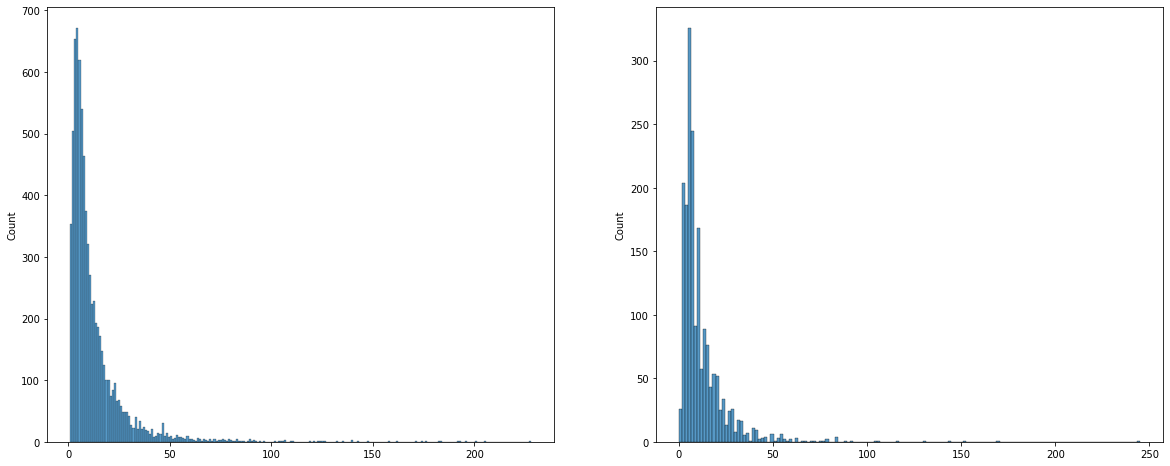

In [74]:
length_train = [len(s) for s in X_train]
length_test = [len(s) for s in X_test]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
sns.histplot(x=length_train,ax=ax[0])
sns.histplot(x=length_test,ax=ax[1])

In [75]:
X_train_norm = pad_sequences(X_train,maxlen=40)
X_test_norm = pad_sequences(X_test,maxlen=40)

In [76]:
embedding_dim = 100
hidden_units = 128

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model = Sequential()
model.add(Embedding(number_vocab, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train_norm, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         272900    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 390,277
Trainable params: 390,277
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
94/94 [==============================] - 2s 11ms/step - loss: 0.6055 - acc: 0.6651 - val_loss: 1.0514 - val_acc: 0.5050

Epoch 00001: val_acc improved from -inf to 0.50504, saving model to ./model\best_model.h5
Epoch 2/15
94/94 [==============================] - 1s 8ms/step - loss: 0.4366 - acc: 0.8037 - val_loss: 1.1001 - val_acc: 0.6575

Epoch 00002: val_acc impr

In [77]:
loaded_model = load_model('./model/best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_norm, y_test)[1]))

59/59 [==============================] - 0s 3ms/step - loss: 0.5154 - acc: 0.7600

 테스트 정확도: 0.7600
